# Localizer Behavioral Data & Onset Generation

In [46]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import os

# for plotting
sns.set(style='ticks', context='poster', font_scale=1.3)
%matplotlib inline


In [47]:
# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([0], dtype=int32)

## Gather experiment info

In [48]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/localizer')
dirs['datadir'] = op.join(dirs['basedir'], 'data/')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [49]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info

,subid,group,remove
0,loc100,control,NaN
1,loc101,control,NaN
2,loc102,control,NaN
3,loc103,control,NaN
4,loc104,control,NaN
5,loc105,control,NaN
6,loc106,control,NaN
7,loc107,control,NaN
8,loc108,control,NaN
9,loc109,control,NaN


## Load in data

In [50]:
dl = pd.DataFrame()

for subid in subj_info.subid:
    print subid
    
    # add study file
    study_file = op.join(dirs['datadir'], subid, subid + '_behav_localizer.csv')
    d = pd.read_csv(study_file)
    d['subid'] = subid
    dl = dl.append(d, ignore_index=True)
    
# Merge with subj_info
dl = dl.merge(subj_info, on='subid', how='outer')

loc100
loc101
loc102
loc103
loc104
loc105
loc106
loc107
loc108
loc109
loc110
loc111
loc113
loc114
loc115
loc116
loc117
loc118
loc119
loc120
loc121
loc122
loc158
loc150
loc151
loc152
loc153
loc154
loc155
loc156
loc157
loc159
loc160
loc161
loc162
loc163
loc164
loc165
loc166
loc167
loc168
loc169
loc170
loc172
loc171
loc173
loc174


In [51]:
dl.head()

,index,run,trial,onset,duration,cond,subcond,resp,acc,respRT,ISIresp,ISIacc,ISIrespRT,subid,group,remove
0,1,1,1,12.0068,1.4946,object,manmade,NR,0,999.0,manmade,1,0.3153,loc100,control,NaN
1,2,1,2,13.9136,1.0869,object,manmade,NR,0,999.0,manmade,1,0.3784,loc100,control,NaN
2,3,1,3,15.0290,1.4716,object,natural,NR,0,999.0,natural,1,0.1792,loc100,control,NaN
3,4,1,4,16.5293,1.4712,object,manmade,NR,0,999.0,manmade,1,0.1867,loc100,control,NaN
4,5,1,5,18.0304,1.4701,object,natural,NR,0,999.0,natural,1,0.0906,loc100,control,NaN


In [52]:
len(dl.subid.unique())

47

In [53]:
dl.groupby(['subid', 'group']).mean().reset_index().groupby('group').count().subid

group
control    23
stress     24
Name: subid, dtype: int64

### Deal with no responses (NR): Set ISI resp as resp

In [54]:
dl.loc[dl.resp == 'NR', 'respRT'] = dl.loc[dl.resp == 'NR', 'ISIrespRT'] + .5 # adjust for stimTime
dl.loc[dl.resp == 'NR', 'acc'] = dl.loc[dl.resp == 'NR', 'ISIacc']
dl.loc[dl.resp == 'NR', 'resp'] = dl.loc[dl.resp == 'NR', 'ISIresp']

drop_cols = ['ISIrespRT', 'ISIresp', 'ISIacc', 'remove', 'index']
dl.drop(drop_cols, 1, inplace=True)

# Correct duration of image trials by subtracting ITI (1s fix)
dl['duration_adj'] = dl.duration
dl.ix[dl.cond != 'rest', 'duration_adj'] = dl.ix[dl.cond != 'rest', 'duration_adj'] - 1 # subtract ITI

In [55]:
dl.head()

,run,trial,onset,duration,cond,subcond,resp,acc,respRT,subid,group,duration_adj
0,1,1,12.0068,1.4946,object,manmade,manmade,1,0.8153,loc100,control,0.4946
1,1,2,13.9136,1.0869,object,manmade,manmade,1,0.8784,loc100,control,0.0869
2,1,3,15.0290,1.4716,object,natural,natural,1,0.6792,loc100,control,0.4716
3,1,4,16.5293,1.4712,object,manmade,manmade,1,0.6867,loc100,control,0.4712
4,1,5,18.0304,1.4701,object,natural,natural,1,0.5906,loc100,control,0.4701


### Remove time for lead-in (12 s)

In [56]:
dl['onset_adj'] = dl.onset - 12
dl.head()

,run,trial,onset,duration,cond,subcond,resp,acc,respRT,subid,group,duration_adj,onset_adj
0,1,1,12.0068,1.4946,object,manmade,manmade,1,0.8153,loc100,control,0.4946,0.0068
1,1,2,13.9136,1.0869,object,manmade,manmade,1,0.8784,loc100,control,0.0869,1.9136
2,1,3,15.0290,1.4716,object,natural,natural,1,0.6792,loc100,control,0.4716,3.0290
3,1,4,16.5293,1.4712,object,manmade,manmade,1,0.6867,loc100,control,0.4712,4.5293
4,1,5,18.0304,1.4701,object,natural,natural,1,0.5906,loc100,control,0.4701,6.0304


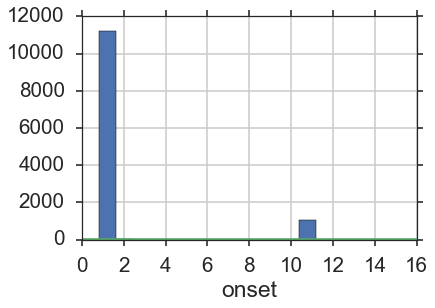

In [57]:
durations = dl.onset - dl.onset.shift(1)
durations[durations > -5].hist(bins=20)
sns.distplot(durations[durations > -5])

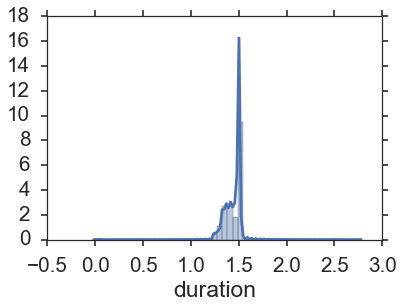

In [58]:
sns.distplot(dl[dl.duration_adj < 5].duration)

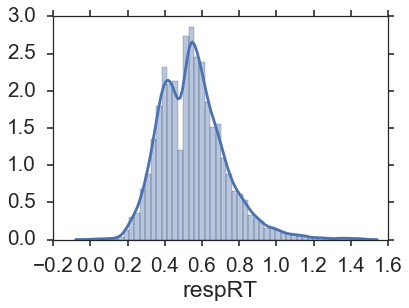

In [59]:
sns.distplot(dl[~dl.resp.isin(['NR', 'rest'])].respRT)

## Switch Costs

In [60]:
dl_switch = dl[dl.cond != 'rest']
dl_switch['switch'] = dl_switch.cond ==  dl_switch.cond.shift(1)
dl_switch.switch = dl_switch.switch.apply(lambda x: 0 if x == True else 1)

for increment in [1, 2, 3, 4, 5]:
    dl_switch.switch = np.nansum([dl_switch.switch, 
                                  dl_switch.switch.apply(lambda x: 0 if x < increment else x+1).shift(1)], axis=0)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


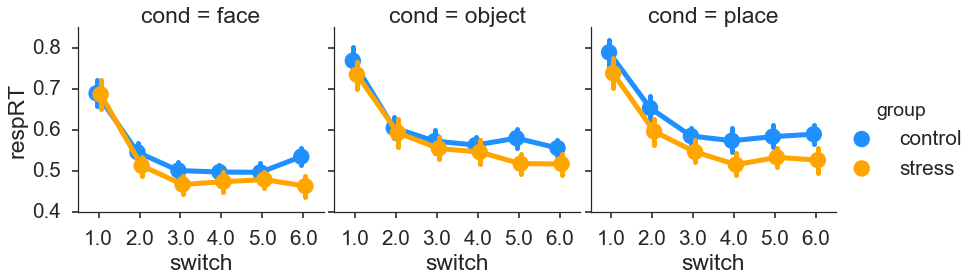

In [61]:
dl_resp = dl_switch[(dl_switch.resp != 'NR') & (dl_switch.switch > 0)]
means = dl_resp.groupby(['subid', 'switch', 'group', 'cond', 'subcond', 'acc']).mean().reset_index()

sns.factorplot(x='switch', hue='group', y='respRT', col='cond', 
               units='subid', ci=68, dodge=.1,palette=['dodgerblue', 'orange'],
               data=means.query('acc == 1'))

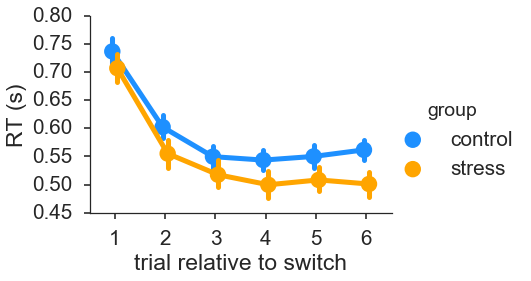

In [62]:
dl_resp = dl_switch[(dl_switch.resp != 'NR') & (dl_switch.switch > 0)]
means = dl_resp.groupby(['subid', 'switch', 'group', 'acc']).mean().reset_index()
means.switch = means.switch.astype(int)

g = sns.factorplot(x='switch', hue='group', y='respRT', aspect=1.5,
               units='subid', ci=68, dodge=.1, palette=['dodgerblue', 'orange'],
               data=means.query('acc == 1'))
g.set_xlabels('trial relative to switch')
g.set_ylabels('RT (s)')

plt.savefig('/Users/sgagnon/Dropbox/Stanford/Presentations/AP/behav_loc_RTs_switch_acc.png')

## Analyze RTs

In [63]:
dl.head()

,run,trial,onset,duration,cond,subcond,resp,acc,respRT,subid,group,duration_adj,onset_adj
0,1,1,12.0068,1.4946,object,manmade,manmade,1,0.8153,loc100,control,0.4946,0.0068
1,1,2,13.9136,1.0869,object,manmade,manmade,1,0.8784,loc100,control,0.0869,1.9136
2,1,3,15.0290,1.4716,object,natural,natural,1,0.6792,loc100,control,0.4716,3.0290
3,1,4,16.5293,1.4712,object,manmade,manmade,1,0.6867,loc100,control,0.4712,4.5293
4,1,5,18.0304,1.4701,object,natural,natural,1,0.5906,loc100,control,0.4701,6.0304


In [64]:
dl_med = dl.loc[(dl.cond.isin(['face', 'object', 'place'])) & 
                (dl.acc == 1) &
                (dl.resp != 'NR')].groupby(['subid', 'group', 'cond']).median().reset_index()
dl_med.to_csv('/Volumes/group/awagner/sgagnon/AP/behav/localizer_medRT.csv')

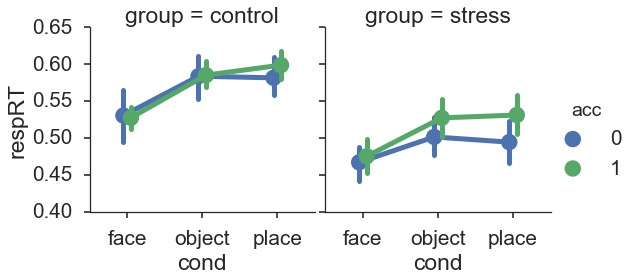

In [65]:
dl_resp = dl[(dl.resp != 'NR') & (dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond', 'acc']).median().reset_index()

sns.factorplot(x='cond', hue='acc', y='respRT', col='group',
               units='subid', ci=68, dodge=.1,
               data=means)

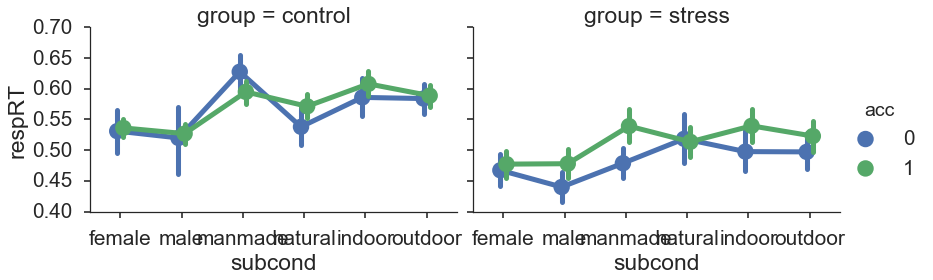

In [66]:
dl_resp = dl[(dl.resp != 'NR') & (dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond', 'subcond', 'acc']).median().reset_index()

sns.factorplot(x='subcond', aspect=1.5,
               order=['female', 'male', 'manmade', 'natural', 'indoor', 'outdoor'],
               hue='acc', y='respRT', col='group',
               units='subid', ci=68, dodge=.1,
               data=means)

## Analyze Accuracy

In [67]:
dl.head()

,run,trial,onset,duration,cond,subcond,resp,acc,respRT,subid,group,duration_adj,onset_adj
0,1,1,12.0068,1.4946,object,manmade,manmade,1,0.8153,loc100,control,0.4946,0.0068
1,1,2,13.9136,1.0869,object,manmade,manmade,1,0.8784,loc100,control,0.0869,1.9136
2,1,3,15.0290,1.4716,object,natural,natural,1,0.6792,loc100,control,0.4716,3.0290
3,1,4,16.5293,1.4712,object,manmade,manmade,1,0.6867,loc100,control,0.4712,4.5293
4,1,5,18.0304,1.4701,object,natural,natural,1,0.5906,loc100,control,0.4701,6.0304


In [68]:
dl_resp = dl.loc[(dl.cond != 'rest')]
dl_resp.to_csv('/Volumes/group/awagner/sgagnon/AP/behav/localizer_acc.csv')

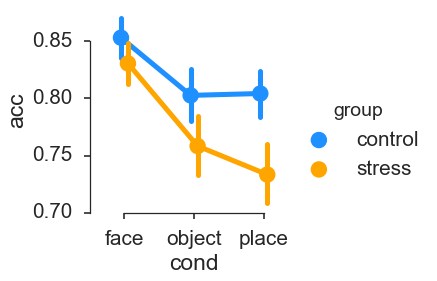

In [70]:
dl_resp = dl[(dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond']).mean().reset_index()

sns.factorplot(x='cond', y='acc', hue='group',
               units='subid', ci=68, dodge=.1, aspect=1.2,
               data=means, palette=['dodgerblue', 'orange'])
sns.despine(trim=True)

plt.savefig('/Users/sgagnon/Dropbox/Stanford/Presentations/AP/behav_loc_acc.png')

In [27]:
dl_resp = dl[(dl.cond == 'place')]
%R -i dl_resp

In [28]:
%%R
str(dl_resp)

'data.frame':	3760 obs. of  13 variables:
 $ run         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trial       : int  67 68 69 70 71 72 73 74 75 76 ...
 $ onset       : num  165 167 168 170 171 ...
 $ duration    : num  1.4 1.4 1.43 1.43 1.43 ...
 $ cond        : Factor w/ 1 level "place": 1 1 1 1 1 1 1 1 1 1 ...
 $ subcond     : Factor w/ 2 levels "indoor","outdoor": 1 2 1 2 1 2 1 2 1 2 ...
 $ resp        : Factor w/ 3 levels "indoor","NR",..: 1 1 1 3 1 3 1 3 1 3 ...
 $ acc         : int  1 0 1 1 1 1 1 1 1 1 ...
 $ respRT      : num  0.721 0.538 0.387 0.68 0.61 ...
 $ subid       : Factor w/ 47 levels "loc100","loc101",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ group       : Factor w/ 2 levels "control","stress": 1 1 1 1 1 1 1 1 1 1 ...
 $ duration_adj: num  0.404 0.404 0.43 0.433 0.43 ...
 $ onset_adj   : num  153 155 156 158 159 ...


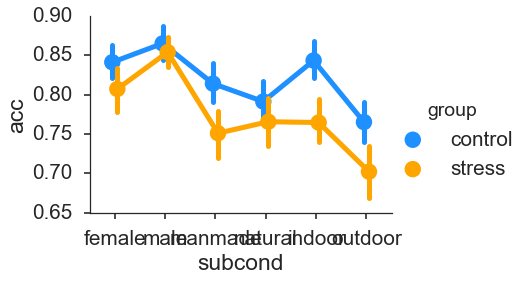

In [30]:
dl_resp = dl[(dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond', 'subcond']).mean().reset_index()

sns.factorplot(x='subcond', aspect=1.5,
               order=['female', 'male', 'manmade', 'natural', 'indoor', 'outdoor'],
               y='acc', hue='group', palette=['dodgerblue', 'orange'],
               units='subid', ci=68, dodge=.1,
               data=means)

---

## Generate onset files

Each csv file must have a column for `run`, `condition`, `onset`, `duration`, and `value`

In [33]:
output_filename = 'localizer_subcat.csv'
output_dir = '/Volumes/group/awagner/sgagnon/AP/data'

for subid in subj_info.subid:
    print subid
    
    dsub = dl.loc[(dl.subid == subid) & (dl.cond != 'rest')]
    ddesign = pd.DataFrame({'run': dsub.run + 6,
                            'condition': dsub.subcond,
                            'onset': dsub.onset_adj,
                            'value': 1})
    
    sub_output_dir = op.join(output_dir, subid.replace('loc', 'ap'), 'design')
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

loc100
loc101
loc102
loc103
loc104
loc105
loc106
loc107
loc108
loc109
loc110
loc111
loc113
loc114
loc115
loc116
loc117
loc118
loc119
loc120
loc121
loc122
loc158
loc150
loc151
loc152
loc153
loc154
loc155
loc156
loc157
loc159
loc160
loc161
loc162
loc163
loc164
loc165
loc166
loc167
loc168
loc169
loc170
loc172
loc171
loc173
loc174


In [23]:
output_filename = 'localizer_cond.csv'
output_dir = '/Volumes/group/awagner/sgagnon/AP/data'

for subid in subj_info.subid:
    print subid
    
    dsub = dl[(dl.subid == subid) & (dl.cond != 'rest')]
    ddesign = pd.DataFrame({'run': dsub.run,
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': 0.5,
                            'value': 1})
    
    sub_output_dir = op.join(output_dir, subid.replace('loc', 'ap'), 'design')
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

loc100
loc101
loc102
loc103
loc104
loc105
loc107
loc108
loc109
loc110
loc111
loc113
loc114
loc115
loc116
loc117
loc118
loc119
loc120
loc121
loc122
loc158
loc150
loc151
loc152
loc153
loc154
loc155
loc156
loc157
loc159
loc160
loc161
loc162
loc163
loc164
loc165
loc166
loc167
loc168
loc169
loc170
loc172
loc171
loc173
loc174


In [24]:
output_filename = 'localizer_cond_dur=RT.csv'
output_dir = '/Volumes/group/awagner/sgagnon/AP/data'

for subid in subj_info.subid:
    print subid
    
    dsub = dl[(dl.subid == subid) & (dl.cond != 'rest')]
    ddesign = pd.DataFrame({'run': dsub.run,
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': dsub.respRT,
                            'value': 1})
    
    sub_output_dir = op.join(output_dir, subid.replace('loc', 'ap'), 'design')
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

loc100
loc101
loc102
loc103
loc104
loc105
loc107
loc108
loc109
loc110
loc111
loc113
loc114
loc115
loc116
loc117
loc118
loc119
loc120
loc121
loc122
loc158
loc150
loc151
loc152
loc153
loc154
loc155
loc156
loc157
loc159
loc160
loc161
loc162
loc163
loc164
loc165
loc166
loc167
loc168
loc169
loc170
loc172
loc171
loc173
loc174


In [25]:
output_filename = 'localizer_cond_mvpa.csv'
output_dir = '/Volumes/group/awagner/sgagnon/AP/data'

for subid in subj_info.subid:
    print subid
    
    dsub = dl[(dl.subid == subid)] # & (dl.cond != 'rest')
    ddesign = pd.DataFrame({'run': dsub.run + 6,
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': 0.5,
                            'value': 1})
    
    ddesign.to_csv(op.join(output_dir, subid.replace('loc', 'ap'), 
                           'design', output_filename), index=False)

loc100
loc101
loc102
loc103
loc104
loc105
loc107
loc108
loc109
loc110
loc111
loc113
loc114
loc115
loc116
loc117
loc118
loc119
loc120
loc121
loc122
loc158
loc150
loc151
loc152
loc153
loc154
loc155
loc156
loc157
loc159
loc160
loc161
loc162
loc163
loc164
loc165
loc166
loc167
loc168
loc169
loc170
loc172
loc171
loc173
loc174


(array([ 43.,  26.,  16.,  10.,   4.,   0.,   0.,   0.,   0.,   1.]),
 array([  5.02629162,   5.68389626,   6.34150089,   6.99910552,
          7.65671015,   8.31431478,   8.97191942,   9.62952405,
         10.28712868,  10.94473331,  11.60233794]),
 <a list of 10 Patch objects>)

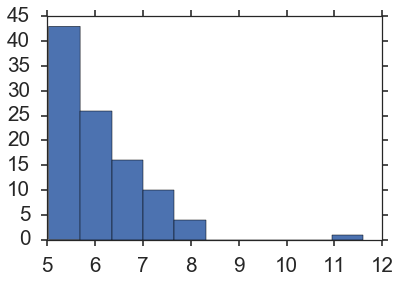

In [45]:
plt.hist(sp.stats.expon.rvs(5,1, size=100))